In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d francoisraucent/western-europe-power-consumption -f de.csv

de.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip de.csv

Archive:  de.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  de.csv.zip
replace de.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: de.csv                  


In [ ]:
!pip install sktime

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,9)
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from google.colab import files, data_table
data_table.enable_dataframe_formatter()
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [ ]:
data = pd.read_csv('de.csv')
data.isnull().sum()

start    0
end      0
load     7
dtype: int64

In [ ]:
data["load"].fillna(data["load"].median(skipna = True), inplace = True)
data.isnull().sum()

start    0
end      0
load     0
dtype: int64

In [ ]:
data.drop(index=data.index[-1], axis=0, inplace=True)
data_de = data.drop(['end'],axis=1)
data_de.tail()

,start,load
198715,2020-08-31 22:45:00+00:00,42503.0
198716,2020-08-31 23:00:00+00:00,42025.0
198717,2020-08-31 23:15:00+00:00,41833.0
198718,2020-08-31 23:30:00+00:00,41433.0
198719,2020-08-31 23:45:00+00:00,41468.0


In [ ]:
train_set = data_de.loc[data_de['start'] <= '2020-05-24 00:00']
train_set = train_set.set_index("start")
train_set.index = pd.to_datetime(train_set.index)
train_set = train_set.groupby(pd.Grouper(freq="h")).sum()
train_set.tail()

,load
start,
2020-05-23 19:00:00+00:00,180418.0
2020-05-23 20:00:00+00:00,175596.0
2020-05-23 21:00:00+00:00,163118.0
2020-05-23 22:00:00+00:00,149912.0
2020-05-23 23:00:00+00:00,146967.0


In [ ]:
# tmp = train_set.copy()
# y_train = tmp.iloc[44904:,:]
# y_train.shape

y_Train = train_set.copy()
y_Train.shape

(47280, 1)

In [ ]:
test_set = data_de.loc[data_de['start'] > '2020-05-24 00:00']
test_set = test_set.set_index("start")
test_set.index = pd.to_datetime(test_set.index)
test_set = test_set.groupby(pd.Grouper(freq="h")).sum()
test_set.tail()

,load
start,
2020-08-31 19:00:00+00:00,214279.0
2020-08-31 20:00:00+00:00,199441.0
2020-08-31 21:00:00+00:00,184671.0
2020-08-31 22:00:00+00:00,173378.0
2020-08-31 23:00:00+00:00,166759.0


In [ ]:
y_true = test_set.copy()
y_true = y_true.iloc[:2376]
y_true.shape

(2376, 1)

In [ ]:
data_de = data[['start', 'load']]
data_de['start'] = pd.to_datetime(data_de['start'])
data_de = data_de.set_index("start")
data_de = data_de.groupby(pd.Grouper(freq="h")).sum()
data_de['start'] = pd.to_datetime(data_de.index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


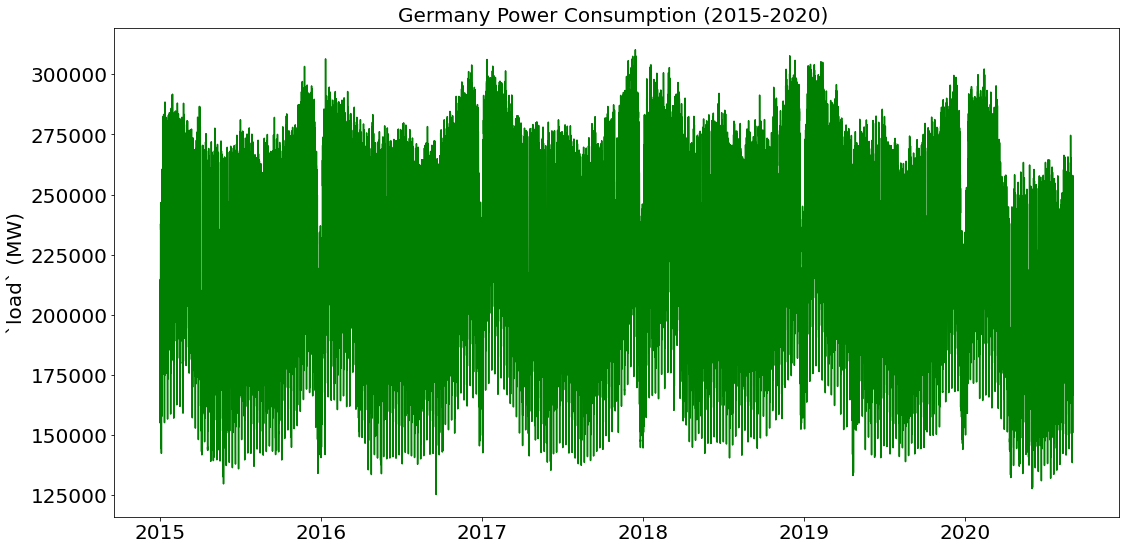

In [ ]:
plt.figure()
plt.plot(data_de['start'], data_de['load'], 'g')
plt.ylabel("`load` (MW)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Germany Power Consumption (2015-2020) ',fontsize=20)
plt.savefig('image1.png', format='png')
plt.show()

In [ ]:
#%% Boxplots
"""[2]"""
df = data_de.set_index("start")
df.index = pd.to_datetime(df.index)

In [ ]:
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime("%b") for d in df.index]

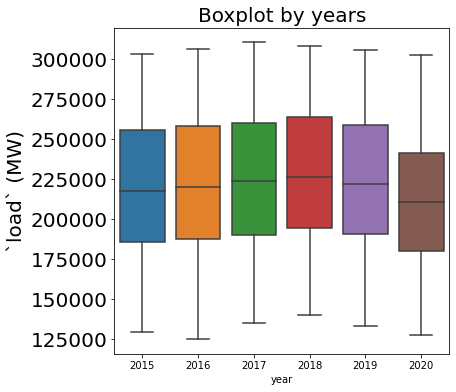

In [ ]:
plt.figure(figsize=(6,6))
sns.boxplot(x='year', y='load', data=df)
plt.ylabel("`load` (MW)", fontsize=20)
plt.yticks(fontsize=20)
plt.title('Boxplot by years',fontsize=20)
plt.savefig('image2.png', format='png')
plt.show()

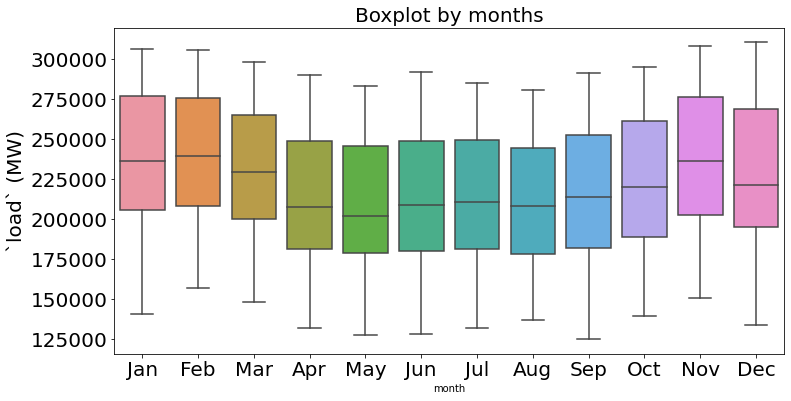

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='load', data=df)
plt.ylabel("`load` (MW)", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Boxplot by months',fontsize=20)
plt.savefig('image3.png', format='png')
plt.show()

In [ ]:
#%%scaling, train_test_split
"""[3]"""
scaler = StandardScaler()
scaler = scaler.fit(train_set[['load']])

In [ ]:
train_set['load'] = scaler.transform(train_set[['load']])
test_set['load'] = scaler.transform(test_set[['load']])

In [ ]:
last_n = 24

In [ ]:
def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []
    for i in range(len(x)-last_n):
        x_values.append(x.iloc[i:(i+last_n)].values)
        y_values.append(y.iloc[i+last_n])
    return np.array(x_values), np.array(y_values)

In [ ]:
x_train, y_train = to_sequences(train_set[['load']], train_set['load'], last_n)
x_test, y_test = to_sequences(test_set[['load']], test_set['load'], last_n)

In [ ]:
#%%LSTM Model
model=Sequential()
model.add(LSTM(120,return_sequences=True,input_shape=(last_n,1)))
model.add(LSTM(80,return_sequences=True))
model.add(LSTM(40))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 120)           58560     
                                                                 
 lstm_1 (LSTM)               (None, 24, 80)            64320     
                                                                 
 lstm_2 (LSTM)               (None, 40)                19360     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 142,281
Trainable params: 142,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

1330/1330 [==============================] - 104s 69ms/step - loss: 0.0533 - val_loss: 0.0133


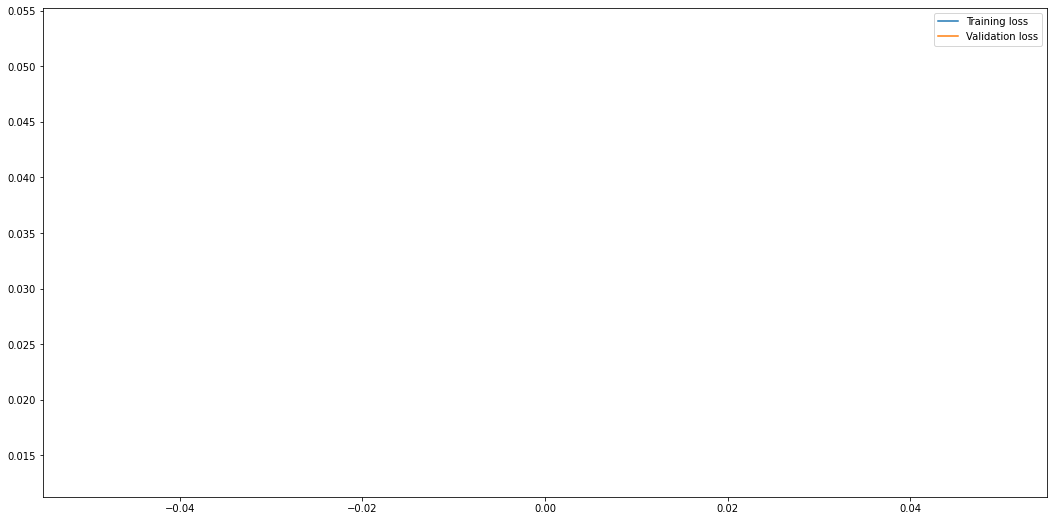

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.savefig('image4.png', format='png')
plt.show()

In [ ]:
#%%Predictions (LSTM)
train_predict = model.predict(x_train)
test_predict  = model.predict(x_test)

In [ ]:
predict_train = scaler.inverse_transform(train_predict)
predict_test  = scaler.inverse_transform(test_predict)

y_pred = predict_test.copy()

In [ ]:
y_pred.shape

(2376, 1)

In [ ]:
#%%Visualization of predictions(test_set)
previous_days = last_n

In [ ]:
testPredictPlot = np.empty_like(df['load'])
testPredictPlot[:] = np.nan
testPredictPlot = testPredictPlot.reshape(-1,1)
testPredictPlot[len(train_predict)+(previous_days*2):len(df), :] = predict_test

In [ ]:
df_tpp = pd.DataFrame(data=testPredictPlot, columns=['load'])
df_tpp['start'] = df.index
df_tpp['start'] = pd.to_datetime(df_tpp['start'])
df_tpp = df_tpp.set_index("start")

In [ ]:
df_predict = df['load']

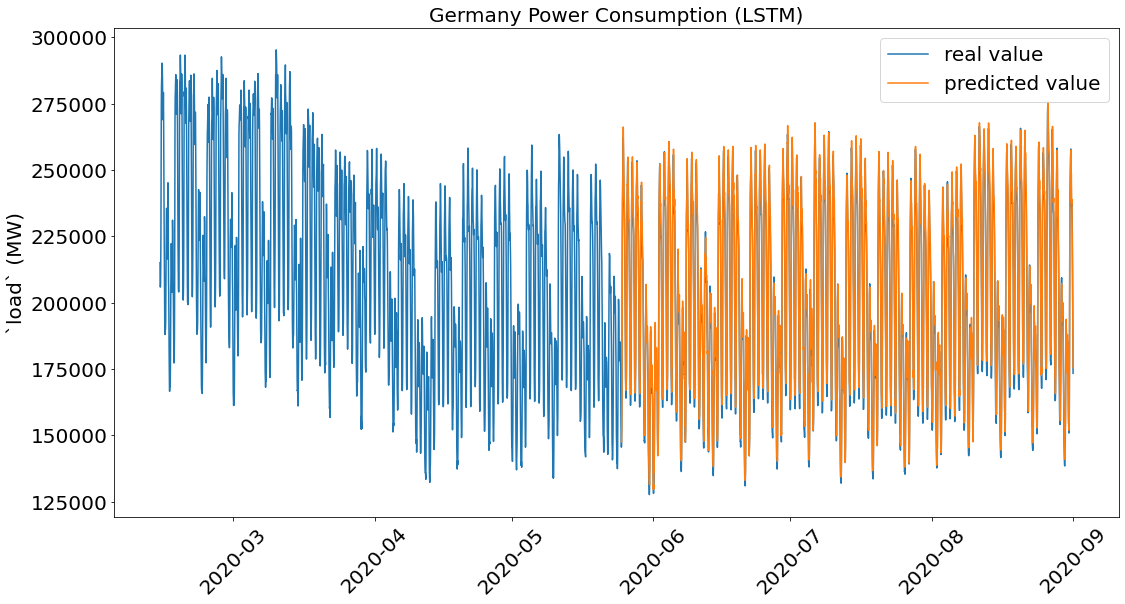

In [ ]:
plt.figure()
plt.plot(df_predict[44879:49679],label='real value')
plt.xticks(rotation=45)
plt.ylabel("`load` (MW)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Germany Power Consumption (LSTM)',fontsize=20)
plt.plot(df_tpp[47279:49679],label='predicted value')
plt.xticks(rotation=45)
plt.legend(fontsize=20)
plt.savefig('image5.png', format='png')
plt.show()

In [ ]:
y_pred.sum()

481885730.0

In [ ]:
print('ME :',(y_pred.sum()-y_true.sum())/2376)
print('RMSE :',mean_squared_error(y_true, y_pred, squared=False))
print('MAE :', mean_absolute_error(y_true, y_pred))
print('MPE :', ((y_pred.sum()-y_true.sum())/23.76)/y_true.mean())
print('MAPE :', mean_absolute_percentage_error(y_true, y_pred))
print('MASE :', mean_absolute_scaled_error(y_true, y_pred, y_train=y_Train))

ME : load    2676.534512
dtype: float64
RMSE : 24358.735985852592
MAE : 16052.537556555135
MPE : load    1.337349
dtype: float64
MAPE : 0.08509848773696854
MASE : 2.0487891281262027
